## Nombre y Apellidos

**Alumno_1:**

**Alumno_2:**

# Proyecto AmI: Clasificación de género musical

En este notebook vamos a aplicar técnicas de *Machine Learning* para **clasificar** diversos géneros musicales de forma automática. Usaremos *features* de las canciones para realizar la clasificación.

Podemos utilizar la base de datos   [GTZAN](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) (o un subconjunto de ella).

GTZAN es una base de datos de 1000 fragmentos de canción (30 segundos de duración) clasificados en 10 tipos/géneros (rock, pop, blues, clásica,...), es decir, conocemos el género de cada canción.

Cada archivo tiene un
* sample_rate = 22kHz (22050Hz),
* bit_depth = 16 bits/sample, y
* canal = *mono*.


## Esquema de implementación del clasificador

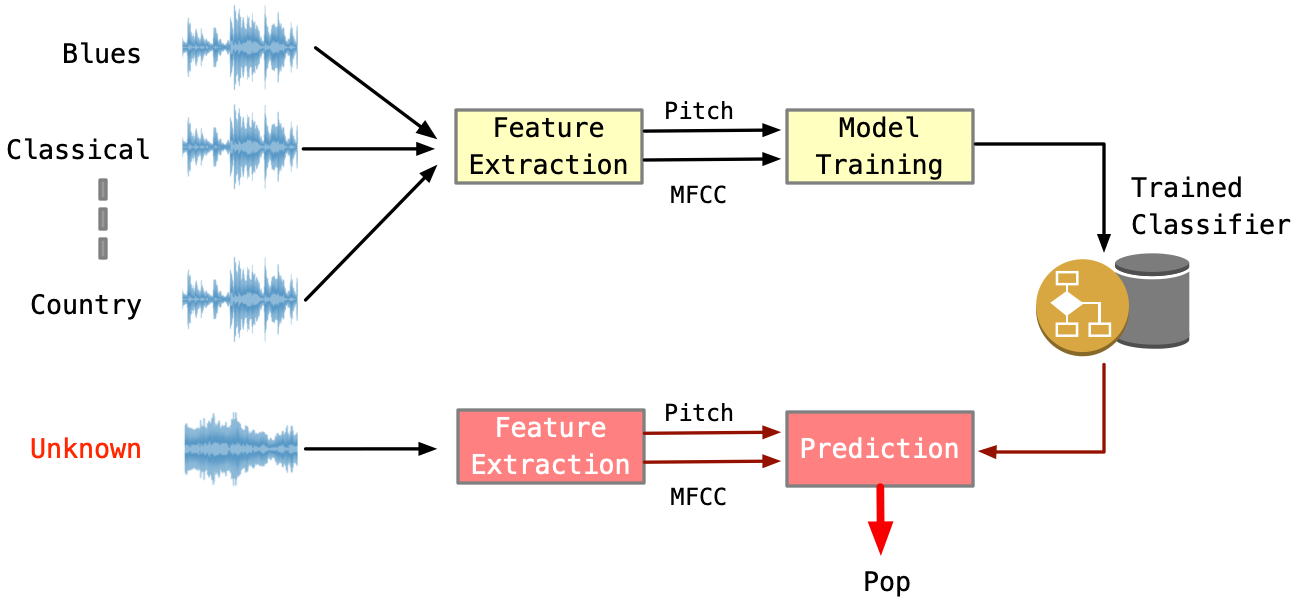

### Feature extraction

El primer paso es obtener las **features** de cada uno de los archivos de audio .wav. El conjunto de features de todas las canciones formarán nuestra matriz $X$.
Entre ellos, los coeficientes cepstrales de Mel (MFCC). MFCC es un tipo de transformación que se emplea habitualmente en procesamiento de audio y se sabe adecuada para la identificación de contenido relevante (genero musical, identificación de un hablante, etc.).

Puede consultarse <a href="https://www.wikiwand.com/es/MFCC"> la entrada de la wikipedia</a> para información más detallada.

Para ello, vamos a utilizar la librería [librosa](https://librosa.org/doc/main/index.html) de análisis de audio.

In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import os
#
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#os.chdir('/content/drive/My Drive/Colab Notebooks/_Music01')
! pwd

/Users/plm/Library/CloudStorage/GoogleDrive-lopez.matencio@gmail.com/My Drive/Colab Notebooks/_Music01


In [ ]:
! rm -r ArchivesT1_AmI/

rm: ArchivesT1_AmI/: No such file or directory


**Descarga de archivos de música, matriz X e y (train y test), y modelo entrenado**

In [ ]:
import requests
import os
from zipfile import ZipFile

shared_url = 'https://bit.ly/3STrPLY'

# Set the path of the directory where you want to save the downloaded files
local_path = './'

# Download the ZIP file
response = requests.get(shared_url)
zip_file_path = os.path.join(local_path, 'ArchivesT1.zip')
with open(zip_file_path, 'wb') as f:
    f.write(response.content)

# Extract the ZIP file
with ZipFile(zip_file_path, 'r') as zip:
    zip.extractall(local_path)

# Delete the ZIP file
os.remove(zip_file_path)

print('Archivos descargados con éxito')

Archivos descargados con éxito


***

* hop_length = 512  is the frame jump length in num. of samples
* n_fft = 2048  is the window in num. of samples

In [ ]:
for i, (root, dirs, files) in enumerate(os.walk("lib_train1")):
    dirs.sort()
    path = root.split(os.sep)
    print( os.path.basename(root),i)
    #for file in files:
    #    print(i, file)

lib_train1 0
classical 1
rock 2


In [ ]:
def features_of_track(song_name_path):
    # Inicializo lista para features
    feature_row = []

    # Split filename and label
    filename = os.path.basename(song_name_path)
    label = os.path.splitext(filename)[0]

    column_names = ['filename', '#samples', 'chroma_cens_mean', 'chroma_cens_var',
                    'chroma_stft_mean', 'chroma_stft_var', 'spectral_centroid_mean', 'spectral_centroid_var',
                    'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'spectral_contrast_mean',
                    'spectral_contrast_var', 'spectral_flatness_mean', 'spectral_flatness_var',
                    'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'tonnetz_mean',
                    'tonnetz_var', 'rms_mean', 'rms_var', 'tempo',
                    'mfcc1_mean','mfcc1_var', 'mfcc2_mean','mfcc2_var',
                    'mfcc3_mean','mfcc3_var','mfcc4_mean', 'mfcc4_var',
                    'mfcc5_mean','mfcc5_var','mfcc6_mean','mfcc6_var',
                    'mfcc7_mean','mfcc7_var','mfcc8_mean','mfcc8_var',
                    'mfcc9_mean','mfcc9_var','mfcc10_mean','mfcc10_var',
                    'mfcc11_mean','mfcc11_var','mfcc12_mean','mfcc12_var',
                    'mfcc13_mean','mfcc13_var','label']

    try:
        # Load audio file
        y, sr = librosa.load(song_name_path)

        # Calculate the number of samples
        num_samples = len(y)

        # Extract features
        chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        spectral_flatness = librosa.feature.spectral_flatness(y=y)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)
        tempo = librosa.feature.rhythm.tempo(y=y, sr=sr)
        #tempo = librosa.beat.tempo(y=y, sr=sr)
        MFCCs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        # compute mean and var of features
        feature_row.extend([filename, num_samples,
                            np.mean(chroma_cens), np.var(chroma_cens),
                            np.mean(chroma_stft), np.var(chroma_stft),
                            np.mean(spectral_centroid), np.var(spectral_centroid),
                            np.mean(spectral_bandwidth), np.var(spectral_bandwidth),
                            np.mean(spectral_contrast), np.var(spectral_contrast),
                            np.mean(spectral_flatness), np.var(spectral_flatness),
                            np.mean(zero_crossing_rate), np.var(zero_crossing_rate),
                            np.mean(tonnetz), np.var(tonnetz),
                            np.mean(rms), np.var(rms),
                            tempo[0],
                            np.mean(MFCCs[0,:]),np.var(MFCCs[0,:]),
                            np.mean(MFCCs[1,:]),np.var(MFCCs[1,:]),
                            np.mean(MFCCs[2,:]),np.var(MFCCs[2,:]),
                            np.mean(MFCCs[3,:]),np.var(MFCCs[3,:]),
                            np.mean(MFCCs[4,:]),np.var(MFCCs[4,:]),
                            np.mean(MFCCs[5,:]),np.var(MFCCs[5,:]),
                           np.mean(MFCCs[6,:]),np.var(MFCCs[6,:]),
                           np.mean(MFCCs[7,:]),np.var(MFCCs[7,:]),
                           np.mean(MFCCs[8,:]),np.var(MFCCs[8,:]),
                           np.mean(MFCCs[9,:]),np.var(MFCCs[9,:]),
                           np.mean(MFCCs[10,:]),np.var(MFCCs[10,:]),
                           np.mean(MFCCs[11,:]),np.var(MFCCs[11,:]),
                           np.mean(MFCCs[12,:]),np.var(MFCCs[12,:]),label])

    except Exception as e:
        print(f'Error processing file {song_name_path}: {e}')
        return None, None  # Si error devuelve None

    return feature_row, column_names

In [ ]:
!pip list | grep librosa

librosa                        0.10.2.post1


In [ ]:
features_of_track("lib_train1/classical/classical.00000.wav")

(['classical.00000.wav',
  661794,
  0.22202358,
  0.034038864,
  0.25236058,
  0.08414862,
  1505.3574607064077,
  44430.73283264175,
  1559.2288947162792,
  43765.37312635047,
  23.372866114000935,
  41.336166678302064,
  0.00090962945,
  8.414188e-07,
  0.0982227015661253,
  0.00043139377691147647,
  -0.01920375319924301,
  0.025915841946557643,
  0.036233008,
  0.00022101671,
  95.703125,
  -268.21857,
  1791.9358,
  135.68166,
  188.9014,
  -34.056377,
  231.39032,
  25.616007,
  169.41429,
  -12.971723,
  71.249275,
  17.903265,
  74.56209,
  -9.99086,
  114.86929,
  5.634088,
  65.84176,
  -14.143673,
  75.42844,
  7.4931846,
  177.21745,
  -3.9764395,
  106.70967,
  8.258308,
  80.11543,
  -1.3336011,
  154.7423,
  'classical.00000'],
 ['filename',
  '#samples',
  'chroma_cens_mean',
  'chroma_cens_var',
  'chroma_stft_mean',
  'chroma_stft_var',
  'spectral_centroid_mean',
  'spectral_centroid_var',
  'spectral_bandwidth_mean',
  'spectral_bandwidth_var',
  'spectral_contrast_

#### Recuperar features y labels de **ENTRENAMIENTO**:

In [ ]:
features_pd = pd.read_csv(r'mytrain1.csv')

In [ ]:
features_pd

,filename,#samples,chroma_cens_mean,chroma_cens_var,chroma_stft_mean,chroma_stft_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,label
0,classical.00000.wav,661794,0.222197,0.033962,0.252392,0.084153,1505.166424,44457.891741,1559.005740,43682.973267,...,75.537090,7.490303,177.036100,-3.969332,106.864880,8.258574,80.119270,-1.335327,154.534010,classical
1,classical.00001.wav,661794,0.191238,0.046761,0.214995,0.085010,1360.643672,61611.212848,1441.243134,32378.729688,...,76.726610,-0.849830,82.189575,-7.808103,98.431046,3.525355,117.615980,5.048823,192.858700,classical
2,classical.00002.wav,661794,0.231388,0.029793,0.277958,0.083759,1490.275364,38993.337531,1600.115744,31200.899044,...,50.834614,4.219429,77.911620,-11.827601,60.403748,8.911826,67.262630,-1.431638,99.733550,classical
3,classical.00003.wav,661794,0.182895,0.049883,0.234229,0.083451,1526.629882,91344.309888,1499.439342,60196.227560,...,93.047150,5.224090,73.665790,-0.653077,125.600040,2.794031,173.143200,7.235353,151.135330,classical
4,classical.00004.wav,661794,0.215584,0.036857,0.221574,0.084999,1705.563259,68132.453459,1646.064010,25963.458284,...,96.478905,8.268572,96.748726,-17.982002,184.843120,-1.185533,161.261410,-6.355772,104.342650,classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,rock.00070.wav,661794,0.240225,0.025625,0.367971,0.087689,2511.603900,393133.862949,2244.999644,88102.249583,...,94.760735,3.971214,132.564100,-19.755735,76.588300,0.484813,64.940186,-4.507318,78.668690,rock
146,rock.00071.wav,661794,0.263632,0.013832,0.454341,0.078455,2025.156662,218789.668497,2215.378603,71352.677638,...,90.771390,18.438425,68.121620,-6.940276,63.890057,13.031335,42.992596,-11.585790,42.415733,rock
147,rock.00072.wav,661794,0.263101,0.014111,0.403435,0.084467,1933.348573,422482.933247,2211.314489,96106.220985,...,52.669070,16.498878,69.222270,-7.862703,46.683296,11.873174,49.458360,-11.193713,42.172928,rock
148,rock.00073.wav,661794,0.268471,0.011256,0.458529,0.074670,2223.937480,292577.658740,2287.733702,52772.345554,...,55.063713,18.022090,68.150870,-11.675249,38.505894,11.473425,46.463450,-9.827125,40.042550,rock


In [ ]:
# El target debe ser numérico y debo codificar las
# etiquetas.
# Codificamos las etiquetas del género musical por
# valores enteros:
# classical -> 0
# rock -> 1
class_encod = features_pd.iloc[:,-1] # última columna
le = LabelEncoder() # generamos el conversor
y = le.fit_transform(class_encod) # aplicamos el conversor
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

***

In [ ]:
# Formamos la matrix de features pero quitamos las columnas con el
# nombre del archivo, el núm de muestras y la etiqueta (resultado)
X_train = np.array(
    features_pd.drop(labels=['filename','#samples','label'],axis='columns'),
    dtype=float)
y_train = y

***
***

#### Recuperar features y labels de **TEST**

In [ ]:
features_pd_test = pd.read_csv(r'mytest1.csv')

In [ ]:
X_test = np.array(
    features_pd_test.drop(labels=['filename','#samples','label'],axis='columns'),
    dtype=float)

In [ ]:
# Codificamos las etiquetas del género musical por
# valores enteros:
# classical -> 0
# rock -> 1
class_encod = features_pd_test.iloc[:,-1] # última columna
converter = LabelEncoder() # generamos el conversor
y_test = converter.fit_transform(class_encod) # aplicamos el conversor
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

***
***

### Support Vector Machine (SVM)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
pipe = Pipeline(
    [ ('scaler', StandardScaler()),
      ('svc', SVC()) ] )

In [ ]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

In [ ]:
pickle.dump(pipe, open('svcmodel1.pkl', 'wb'))

In [ ]:
pickled_svcmodel = pickle.load(open('svcmodel1.pkl', 'rb'))
pickled_svcmodel.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

Training set score: 1.000
Test set score: 0.980
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.96      1.00      0.98        25

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



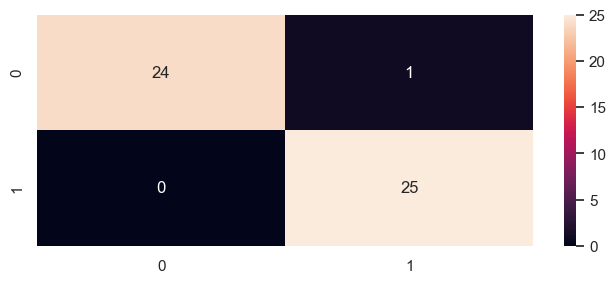

In [ ]:
y_pred=pipe.predict(X_test)
print("Training set score: {:.3f}".format(pipe.score(X_train, y_train)))
print("Test set score: {:.3f}".format(pipe.score(X_test, y_test)))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.set(rc = {'figure.figsize':(8,3)})
sns.heatmap(cf_matrix, annot=True) # con annot ponemos valores en la CM
print(classification_report(y_test,y_pred))

#### Ejemplo: Predicción de una canción

In [ ]:
#c1,_ = features_of_track("lib_test/classical/classical.00076.wav")
d1,_ = features_of_track("lib_test1/rock/rock.00080.wav")
#r1,_ = features_of_track("lib_test/rock/rock.00076.wav")

In [ ]:
#pipe.predict([np.array(d1[2:-1], dtype=float)])
pickled_svcmodel.predict([np.array(d1[2:-1], dtype=float)])

array([1])

In [ ]:
d2,_ = features_of_track("lib_test1/classical/classical.00080.wav")
pickled_svcmodel.predict([np.array(d2[2:-1], dtype=float)])

array([0])

### Predicción
Realizamos predicciones sobre nuevas tracks:

In [ ]:
# Si el modelo no está cargado entonces lo cargamos
if 'pickled_svcmodel' not in globals():
     pickled_svcmodel = pickle.load(open('svcmodel1.pkl', 'rb'))

In [ ]:
TESTPATH = 'lib_test1'
def genrePredict(trackspath = TESTPATH, onetrack=False):
  """
  Realiza la predicción del género musical de las canciones
  contenidas en un directorio, y, también de una sóla canción
  haciendo onetrack= True
  """
  num_classical = 0
  # num_disco = 0
  num_rock = 0
  if not onetrack:
    for root, dirs, files in os.walk(trackspath):
      dirs.sort()
      for file in sorted(files):
        file_path = os.path.join(root, file)
        print(f'Computando features de track: {file} ')
        feat_val, _ = features_of_track(file_path)
        genero = pickled_svcmodel.predict([np.array(feat_val[2:-1], dtype=float)])
        print(f'Género: {genero} ')
        if (genero == 0):
          print('Classical')
          num_classical += 1
        #elif (genero == 1):
        #  print('Disco')
        #  num_disco += 1
        else:
          print('Rock')
          num_rock += 1
        print(f'---> Siguiente canción')
  else:
    #filename = trackspath.split('/')[-1]
    feat_val, _ = features_of_track(trackspath)
    genero = pickled_svcmodel.predict([np.array(feat_val[2:-1], dtype=float)])
    print(f'Género: {genero} ')
    if (genero == 0):
      print('Classical')
      num_classical += 1
    #elif (genero == 1):
    #  print('Disco')
    #  num_disco += 1
    else:
      print('Rock')
      num_rock += 1

  # return list([num_classical, num_disco, num_rock])
  return list([num_classical, num_rock])


In [ ]:
# genrePredict()
genrePredict("lib_test1/classical/classical.00080.wav", True)

Género: [0] 
Classical


[1, 0]

## Clasificación online de género musical

Una vez entrenada la red la usaremos para clasificar el sonido ambiente (usando como fuente de entrada el micrófono). Para ello, recordemos que puede emplear la librería pyaudio con el siguiente código para obtener una grabación:

### Test 0: método de grabación
**Sólo utilizable con la lib `pyAudio` y con Jupyter Notebook ejecutando en el propio PC (NO usar con G Colab)**

In [ ]:
# EJECUTAR ESTA CELDA SOLO SI LA SIGUIENTE CELDA
# NO PUEDE IMPORTAR LA LIBRERÍA PYAUDIO
# !apt install ffmpeg-python ffmpeg
# !apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0
#--
!pip install pyaudio

In [ ]:
import pyaudio
import wave

def getWav(filename='test.wav', tiempo=5, device_index=None,
           rate=48000, chunk=1024):
    # Borrar si existe
    import os
    if os.path.exists(filename):
        os.remove(filename)

    try:
        FORMAT = pyaudio.paInt16
        CHANNELS = 1
        RECORD_SECONDS = tiempo
        WAVE_OUTPUT_FILENAME = filename

        p = pyaudio.PyAudio()

        if device_index is None:
            # Si quieres, aquí puedes seguir buscando por nombre concreto
            info = p.get_host_api_info_by_index(0)
            numdevices = info.get('deviceCount')
            for i in range(numdevices):
                dev = p.get_device_info_by_host_api_device_index(0, i)
                if dev.get('maxInputChannels') > 0:
                    print("Usando dispositivo", i, "-", dev.get('name'))
                    device_index = i
                    break
        else:
            dev = p.get_device_info_by_host_api_device_index(0, device_index)
            print("Usando dispositivo", device_index, "-", dev.get('name'))

        stream = p.open(format=FORMAT,
                        channels=CHANNELS,
                        rate=rate,
                        input=True,
                        input_device_index=device_index,
                        frames_per_buffer=chunk)

        print("Grabando...")

        frames = []
        for _ in range(0, int(rate / chunk * RECORD_SECONDS)):
            data = stream.read(chunk, exception_on_overflow=False)
            frames.append(data)

        print("Grabación finalizada.")

        stream.stop_stream()
        stream.close()
        p.terminate()

        wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(rate)
        wf.writeframes(b''.join(frames))
        wf.close()

    except (ValueError, PermissionError, OSError) as e:
        print("ERROR:", e)
        return False

    return True


In [ ]:
file='test.wav'
getWav(filename=file, tiempo=10)

Usando dispositivo 0 - Built-in Microphone
Grabando...
Grabación finalizada.


True

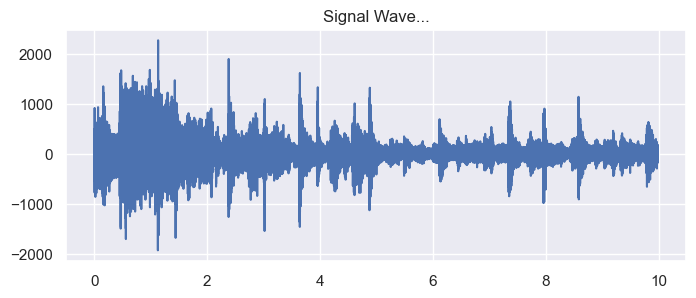

In [ ]:
#Extract Raw Audio from Wav File
with wave.open(file,'r') as wav_file:
    #Extract Raw Audio from Wav File
    signal = wav_file.readframes(-1)
    signal = np.frombuffer(signal, dtype=np.int16)

    #Split the data into channels
    channels = [[] for channel in range(wav_file.getnchannels())]
    for index, datum in enumerate(signal):
        channels[index%len(channels)].append(datum)

    #Get time from indices
    fs = wav_file.getframerate()
    Time=np.linspace(0, len(signal)/len(channels)/fs, num=len(signal)//len(channels))

    #Plot
    plt.figure(1)
    plt.title('Signal Wave...')
    for channel in channels:
        plt.plot(Time,channel)
    plt.show()

ipd.Audio('test.wav')
#audioPlayer('test.wav')

In [ ]:
#genrePredict("debussy.wav", True)
genrePredict("test.wav", True)

Género: [1] 
Rock


[0, 1]

### Prueba de Grabación:

[Red Hot Chili Peppers](https://www.youtube.com/watch?v=YlUKcNNmywk)

[4H Chopin](https://www.youtube.com/watch?v=fzDqfdmvw2o)

### **TAREA 1:**

Escriba un código en python que esté permanentemente a la escucha grabando sonido durante unos segundos, analizando el tipo de canciones y mostrando la predicción por pantalla.

Si contamos con el modelo ya entrenado, entonces debemos cargarlo `pickled_svcmodel` y con él podemos predecir el género musical con la función `genrePredict()` que llama a `features_of_track()`.  

* *Puede completarlo en este mismo Notebook o en uno aparte añadiendo las importaciones de librerías y las funciones necesarias.*

* Suba la solución de la Tarea al AV y ponga el nombre de los integrantes del ejercicio en la primera celda de este notebook.

* Un *esqueleto* posible para el código es el siguiente:

In [ ]:
import time
import os
try:
    while True:
        print('grabando una canción')
        file='test.wav'
        model = 'svcmodel1.pkl'
        # 1. Borramos el archivo .wav para generar
        #    la siguiente predicción


        getWav(filename=file, tiempo=5)
        while not os.path.exists(file):
          time.sleep(1)

        if os.path.isfile(file):
          # 2. Ver si pickled_svc model está y
          #    si no, cargar el modelo


          # 3. Hacer genrePredict()
          #    y mostramos predicción por pantalla


        else:
          raise ValueError("%s wav no está!" % file)

# el script termina con STOP en Jupyter,
# (o con CTRL+C si run desde archivo)
except KeyboardInterrupt:
    print('interrupted!')

## Solución

### Algunas mejoras opcionales de la solución


* Mejora del modelo clasificador. Por ejemplo, incremento de la cantidad de géneros clasificados por el modelo, añadir nuevas *features* útiles que aporten información valiosa para el clasificador, y/o, crear un nuevo modelo usando una técnica de aprendizaje supervisado diferente.

* Los navegadores no pueden capturar audio de calidad por la conversión de formatos que usan las APIs de los navegadores, y, por tanto, no permite usar las posibilidades del hardware de grabación para obtener una buena calidad de audio.
Lo que se puede hacer es mejora la interfaz de usuario. Por ejemplo: Python local + PyAudio + tkinter para GUI simple. Suba los archivos necesarios para realizar esta mejora en un .zip




**Debe entregar este notobook con la solución de la Tarea 1.**

Si realiza alguna de las mejoras propuestas u otra que considere, entréguela en un Notebook de Jupyter independiente a este. Si la mejora consiste en varios archivos, súbalos también comprimiéndolos en un .zip.
Puede añadir un README.txt explicando la en qué consiste la mejora que ha hecho.